
**HW 2/1**: <br>
Smart up our plotter to be able to customize the hard-coded layout setup inside the function. Add more custom feature that you would like to use.

Added features:
- color and style of lines
- linewidth
- xlabel and ylabel
- xlim and ylim
- legend location
- grid option

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib import rcParams # detailed parameter setting
""" more details on customization: https://matplotlib.org/stable/tutorials/introductory/customizing.html """
from typing import Dict, List, Union


# some type hints in the header of the function
def my_plotter(x: List[float], y: Union[List[float], List[List[float]]], linestyle: List[str], color: List[str], layout: Dict = {}, names: List[str] = None,):
    y = [y] if all(isinstance(item, float) for item in y) else y
    plt.figure(figsize=(8,4))
    lines = []
    show_legend = True if names is not None else False
    if names is not None:
        show_legend = True
        if len(names) != len(y):
            raise ValueError("Length of names is not matching with number of plotted y lists.")
    if 'linewidth' not in layout:
        lw=4
    else:
        lw=layout['linewidth']
    for i, y_item in enumerate(y):
        _line = plt.plot(x, y_item, color=color[i], linewidth=lw, linestyle=linestyle[i], label=names[i] if show_legend else None)
        lines.append(_line)
    if show_legend:
        if 'legend_loc' not in layout:
                    plt.legend(fontsize=16, loc='best')
        else:
            plt.legend(fontsize=16, loc=layout['legend_loc'])
    if 'title' in layout:
        plt.title(layout['title'], fontsize=20)
        rcParams['axes.titlepad'] = 30 # moving the title a little further away from the plot
    if 'x_label' in layout:
        plt.xlabel(layout['x_label'], fontsize=16)
        rcParams['axes.labelpad'] = 20 # moving the ax label a little further away from the plot
    if 'y_label' in layout:
        plt.ylabel(layout['y_label'], fontsize=16)
    if "x_lim" in layout:
        plt.xlim(layout["x_lim"])
    if "y_lim" in layout:
        plt.ylim(layout["y_lim"])
    ax = plt.gca()
    if "grid" in layout:
        ax.grid(True, linestyle="--", linewidth=0.5)
    ax = plt.gca() # gca: get current axes
    ax.axhline(linestyle='--', color='black', linewidth=1)
    plt.show()

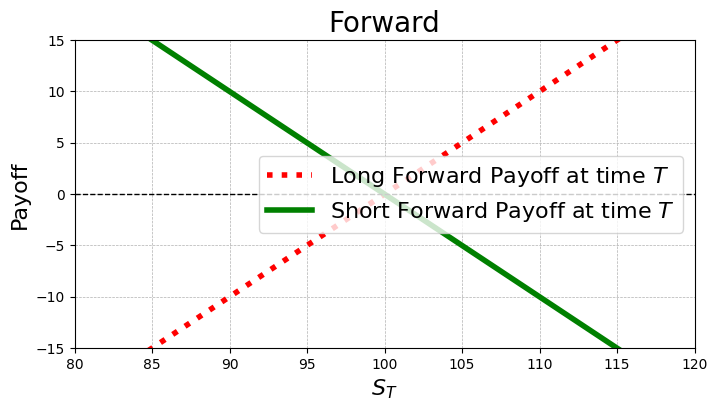

In [2]:
layout = {'title': 'Forward', 'x_label': '$S_{T}$', 'y_label':'Payoff', 'linewidth': 4, 'x_lim':(80, 120), 'y_lim': (-15, 15),'grid': True, 'legend_loc' : "center right"}
K = 100
x_stock_price = np.linspace(80, 120, 100)
y_forward_payoff = x_stock_price-K
y_forward_payoff__short = K - x_stock_price
my_plotter(x_stock_price, [y_forward_payoff, y_forward_payoff__short], layout=layout, names=['Long Forward Payoff at time $T$', 'Short Forward Payoff at time $T$'], color=["red", "green"], linestyle=["dotted", "solid"])

**HW 2/2**: <br>
Upgrade the BSM call option pricer to be able to return the greeks as well, not just the price.

By derivating the BSM pricing formula of European call, we can get analytical solutions for these derivatives of the call option price:

<table>
    <tr>
        <th>Greek</th><th>Formula for call option</th>
    </tr>
    <tr>
        <td>
            \begin{equation}
                \Delta = c'_S
            \end{equation} 
        </td>
        <td>
            \begin{equation}
                N(d_1)
            \end{equation} 
        </td>
    </tr>
    <tr>
        <td>
            \begin{equation}
                \mathcal{V} = c'_\sigma
            \end{equation}
        </td>
        <td>
            \begin{equation}
                S_t \cdot N'_\sigma(d_1) \cdot\sqrt{T-t}
            \end{equation} 
        </td>
    </tr>
    <tr>
        <td>
            \begin{equation}
                \Theta = c'_\tau
            \end{equation}
        </td>
        <td>
            \begin{equation}
                -S_t \cdot N'_t(d_1)\cdot \frac{\sigma}{2\sqrt{T-t}} - r\cdot K\cdot e^{-r(T-t)}\cdot N(d_2)
            \end{equation} 
        </td>
    </tr>
    <tr>
        <td>
            \begin{equation}
                \rho = c'_r
            \end{equation}
        </td>
        <td>
            \begin{equation}
                K\cdot (T-t)\cdot e^{-r(T-t)}\cdot N(d_2)
            \end{equation} 
        </td>
    </tr>
    <tr>
        <td>
            \begin{equation}
                \Gamma = \Delta'_S = c''_{SS}
            \end{equation}
        </td>
        <td>
            \begin{equation}
                N'_S(d_1) \cdot \frac{1}{S_t\cdot\sigma\sqrt{T-t}}
            \end{equation} 
        </td>
    </tr>
</table>

where $N$ is the cummulative distribution function and $N'$ is the probability density function of the standard normal distribution, and
\begin{equation}
d_1 = \frac{log(S_0 / K) + (r + \sigma^2 / 2)T}{\sigma\sqrt{T}}  \quad \text{ and } \quad d_2 = d_1 - \sigma\sqrt{T}.
\end{equation}

In [3]:
"""The pricing function of European call option"""
def black_scholes_eur_call(r: float, T: float, S0: float, sigma: float, K: Union[float, List[float]], greeks=False):
    """
    Black-Scholes pricer of European call option on non-dividend-paying stock

    param r: risk-free interest rate (which is constant)
    param T: time to maturity (in years)
    param S0: initial spot price of the underlying stock
    param sigma: volatility of the underlying stock
    param K: strike price (or prices)
    param greeks: whether we want to return greek values
    """
    assert sigma > 0

    K = np.array([K]) if isinstance(K, float) else np.array(K)

    d1_vec = ( np.log( S0 / K ) + ( r + 0.5 * sigma**2 ) * T ) / ( sigma * T**0.5 )
    d2_vec = d1_vec - sigma * T**0.5

    N_d1_vec = norm.cdf(d1_vec)
    N_d2_vec = norm.cdf(d2_vec)

    price = N_d1_vec * S0 - K * np.exp((-1.0)*r*T) * N_d2_vec
    
    if greeks==False:
        return N_d1_vec * S0 - K * np.exp((-1.0)*r*T) * N_d2_vec
    
    Nv_d1_vec = np.exp(-d1_vec**2/2)/2/np.pi
    
    delta = N_d1_vec
    vega = S0 * T * Nv_d1_vec
    theta = -S0 * Nv_d1_vec * sigma / 2 / np.sqrt(T) - r* K * np.exp((-1.0)*r*T) * N_d2_vec
    rho = K * T *  np.exp((-1.0)*r*T) * N_d2_vec
    gamma = Nv_d1_vec / S0 / sigma / np.sqrt(T)
    
    return [price, delta, vega, theta, rho, gamma]

Example:

In [4]:
results = black_scholes_eur_call(r = 0.05, T = 0.1, S0 = 20.0 , sigma = 0.3, K = 18, greeks=True)
names = ["Price", "Delta", "Vega", "Theta", "Rho", "Gamma"]
for i in range(len(results)):
    print(names[i], round(results[i],3))

Price 2.198
Delta 0.887
Vega 0.153
Theta -1.503
Rho 1.554
Gamma 0.04


**HW 2/3**: <br>
Implement the BSM pricer for European put option.


In [5]:
"""The pricing function of European put option"""
def black_scholes_eur_put(r: float, T: float, S0: float, sigma: float, K: Union[float, List[float]]):
    """
    Black-Scholes pricer of European put option on non-dividend-paying stock

    param r: risk-free interest rate (which is constant)
    param T: time to maturity (in years)
    param S0: initial spot price of the underlying stock
    param sigma: volatility of the underlying stock
    param K: strike price (or prices)
    """
    assert sigma > 0

    K = np.array([K]) if isinstance(K, float) else np.array(K)

    d1_vec = ( np.log( S0 / K ) + ( r + 0.5 * sigma**2 ) * T ) / ( sigma * T**0.5 )
    d2_vec = d1_vec - sigma * T**0.5

    N_d1_vec = norm.cdf(-d1_vec)
    N_d2_vec = norm.cdf(-d2_vec)

    price = -N_d1_vec * S0 + K * np.exp((-1.0)*r*T) * N_d2_vec
    
    return price

Example:

In [6]:
K =[15, 20, 25, 30, 35, 40]
put_price = black_scholes_eur_put(r = 0.05, T = 0.1, S0 = 20.0 , sigma = 0.3, K=K)
for i in range(len(put_price)):
    print("K=", K[i], "p=", round(put_price[i], 5))

K= 15 p= 0.00046
K= 20 p= 0.70594
K= 25 p= 4.88307
K= 30 p= 9.85038
K= 35 p= 14.82544
K= 40 p= 19.8005


**HW 2/4**: <br>
With the call and put pricer, check if Put-Call parity holds in practice.

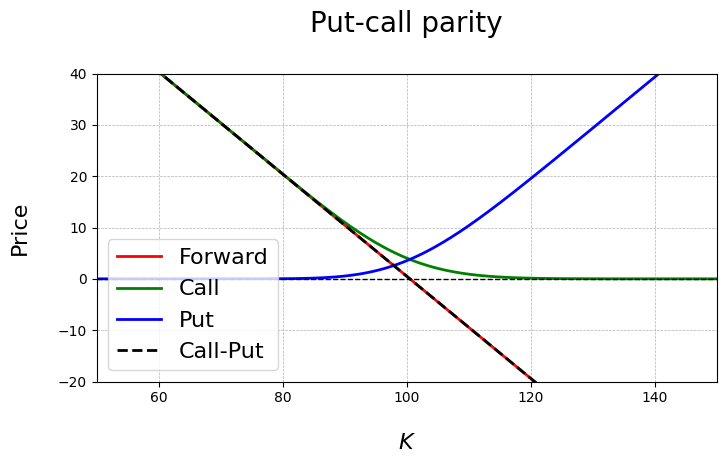

In [7]:
layout = {'title': 'Put-call parity', 'x_label': '$K$', 'y_label':'Price', 'linewidth': 2, 'x_lim':(50, 150), 'y_lim':(-20, 40),'grid': True, 'legend_loc': "lower left"}
S = 100
r = 0.05
T=0.1
K = np.linspace(50, 150, 300)
y_forward = S- K*np.exp(-r*T)
c=black_scholes_eur_call(r = 0.05, T = 0.1, S0 = S , sigma = 0.3, K=K)
p=black_scholes_eur_put(r = 0.05, T = 0.1, S0 = S , sigma = 0.3, K=K)
my_plotter(K, [y_forward, c, p, c-p], layout=layout, names=['Forward', 'Call', 'Put', "Call-Put"], color=["red", "green", "blue", "black"], linestyle=["solid", "solid", "solid", "dashed"])